# Environmental Data Intelligence Platform - Example Analysis
### This notebook demonstrates the analysis capabilities of our platform

In [1]:
import pandas as pd
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
# Import our analysis engine
from src.analysis_engine import WeatherAnalyzer
from src.visualization import VisualizationEngine

### Data Loading and Initialization

In [2]:
# Load the data
df = pd.read_json("data/environmental_sensor_data.json")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

# Initialize the WeatherAnalyzer
# this performs automatic data cleaning, including:
# - automatic identification of cycles in data using Fourier analysis
# - detection and removal of anomalies using MAD on residuals from STL/MSTL decomposition (assuming a 0.16% anomaly rate)
# - imputation using seasonal trends from STL/MSTL decomposition
analyzer = WeatherAnalyzer(df)
visualizer = VisualizationEngine(analyzer)

### Basic Summary

In [3]:
# _cl are the raw data with anomalies removed
# in _filled the missing data points in _cl have been reconstructed
analyzer.get_data_summary()

{'data_info': {'total_records': 8760,
  'date_range': {'start': '2024-01-01T00:00:00', 'end': '2024-12-30T23:00:00'},
  'missing_data': {'temperature_c': np.int64(84),
   'humidity_percent': np.int64(84),
   'air_pressure_hpa': np.int64(84)}},
 'basic_statistics': {'temperature_c': {'count': 8676.0,
   'mean': 12.00840133702167,
   'std': 12.47484271314702,
   'min': -30.26,
   '25%': 2.4,
   '50%': 12.02,
   '75%': 21.6725,
   'max': 61.33},
  'humidity_percent': {'count': 8676.0,
   'mean': 64.80260488704472,
   'std': 18.471143133560172,
   'min': 1.1,
   '25%': 50.2,
   '50%': 65.1,
   '75%': 79.7,
   'max': 109.1},
  'air_pressure_hpa': {'count': 8676.0,
   'mean': 1013.3153953434762,
   'std': 11.569980241260863,
   'min': 936.76,
   '25%': 1005.0274999999999,
   '50%': 1013.335,
   '75%': 1021.64,
   'max': 1128.36},
  'temperature_c_cl': {'count': 8662.0,
   'mean': 12.003626183329485,
   'std': 12.43096354879082,
   'min': -18.96,
   '25%': 2.4,
   '50%': 12.02,
   '75%': 21.6

### Identify present cycles with Fourier analysis

In [4]:
print("temperature")
display(analyzer.identify_cycles(df.temperature_c))
print("humidity")
display(analyzer.identify_cycles(df.humidity_percent))
print("air pressure")
analyzer.identify_cycles(df.air_pressure_hpa)

temperature


,period_hours,freq_hr,amplitude,period_full_days_in_hours
1,23.769863,0.04207,21006.474526,24


humidity


,period_hours,freq_hr,amplitude,period_full_days_in_hours
1,23.769863,0.04207,28350.089587,24


air pressure


,period_hours,freq_hr,amplitude,period_full_days_in_hours
0,166.846154,0.005994,49614.402854,168
1,47.409836,0.021093,14385.905553,48


### Decomposition with STL and anomaly detection on residuals


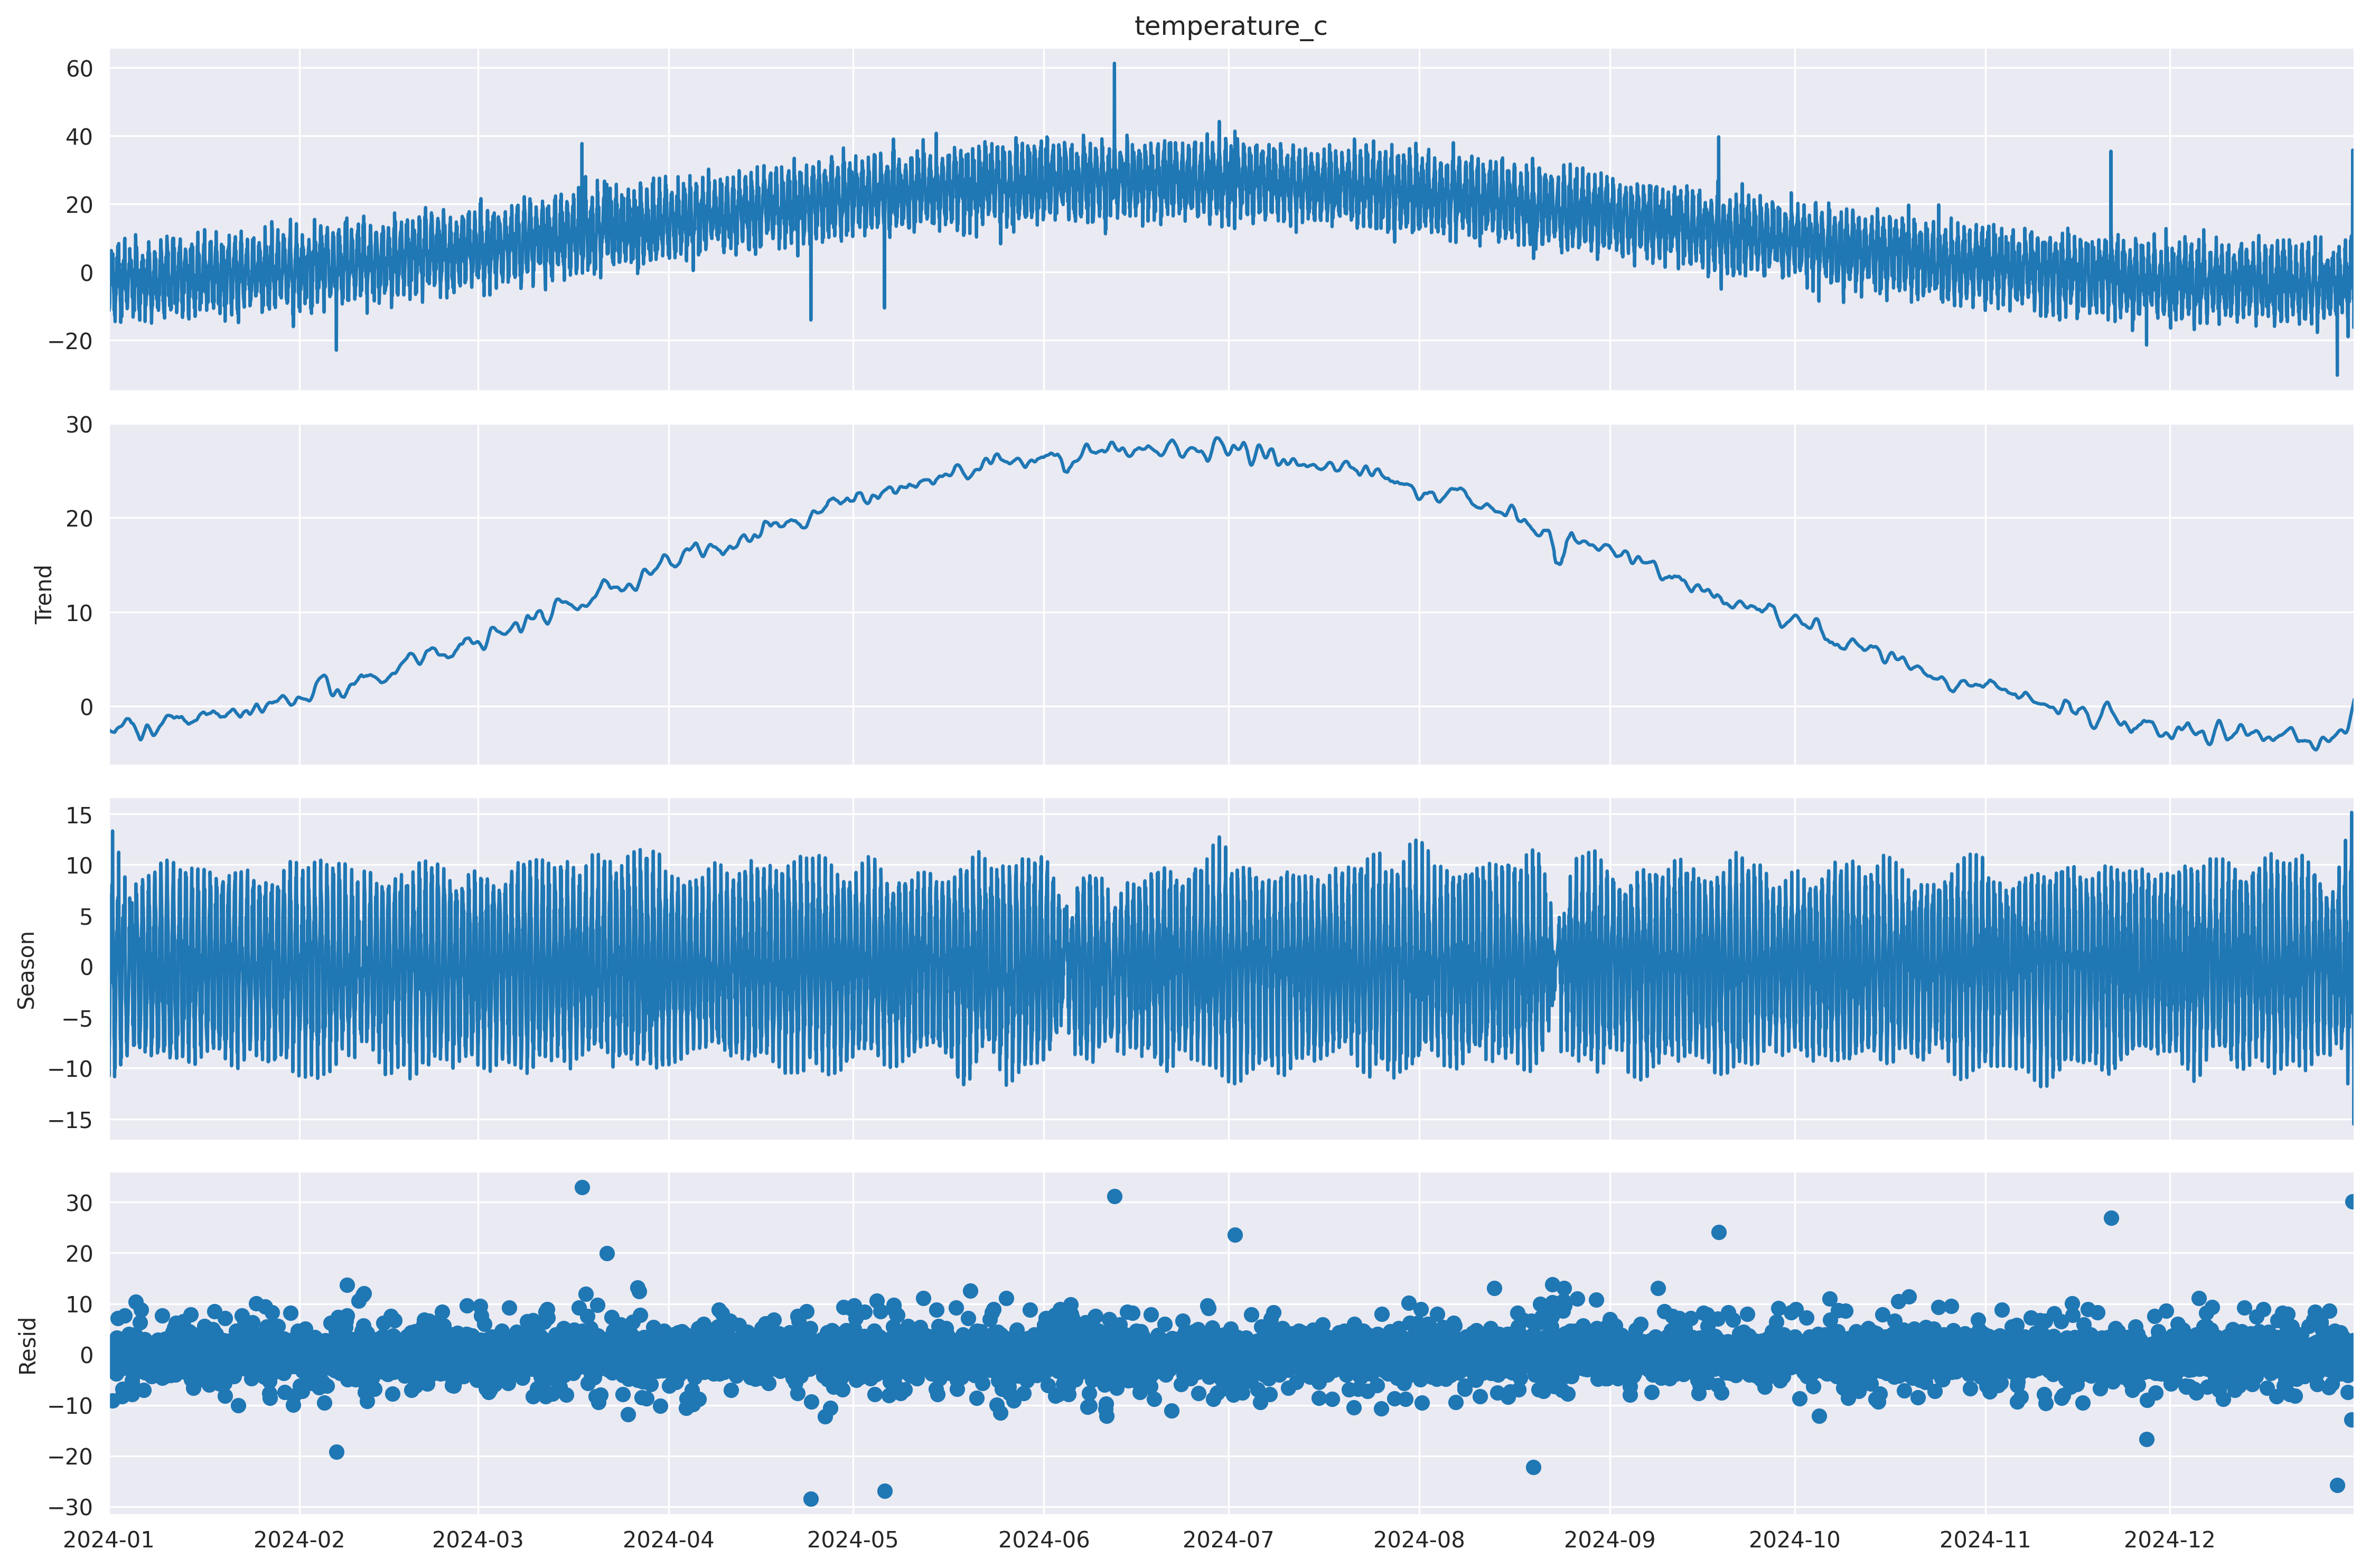

In [5]:
img_b64 = visualizer.decomposition("temperature_c")
display(HTML(f'<img src="data:image/png;base64,{img_b64}">'))

In [6]:
# Get anomalies and threshold
analyzer.get_anomalies("temperature_c", "mad")

(                     temperature_c      score
 timestamp                                    
 2024-02-07 00:00:00         -22.91   9.639266
 2024-03-17 22:00:00          37.76  16.528470
 2024-03-21 23:00:00          25.79   9.993701
 2024-04-24 03:00:00         -14.04  14.275226
 2024-05-06 02:00:00         -10.52  13.492900
 2024-06-12 11:00:00          61.33  15.604000
 2024-07-02 01:00:00          41.40  11.792890
 2024-08-19 14:00:00           4.00  11.122501
 2024-08-22 15:00:00          27.27   6.925109
 2024-09-18 16:00:00          39.73  12.053599
 2024-11-21 10:00:00          35.51  13.463651
 2024-11-27 05:00:00         -21.41   8.342581
 2024-12-28 05:00:00         -30.26  12.886120
 2024-12-30 17:00:00          35.83  15.109231,
 np.float64(6.855597956039487))


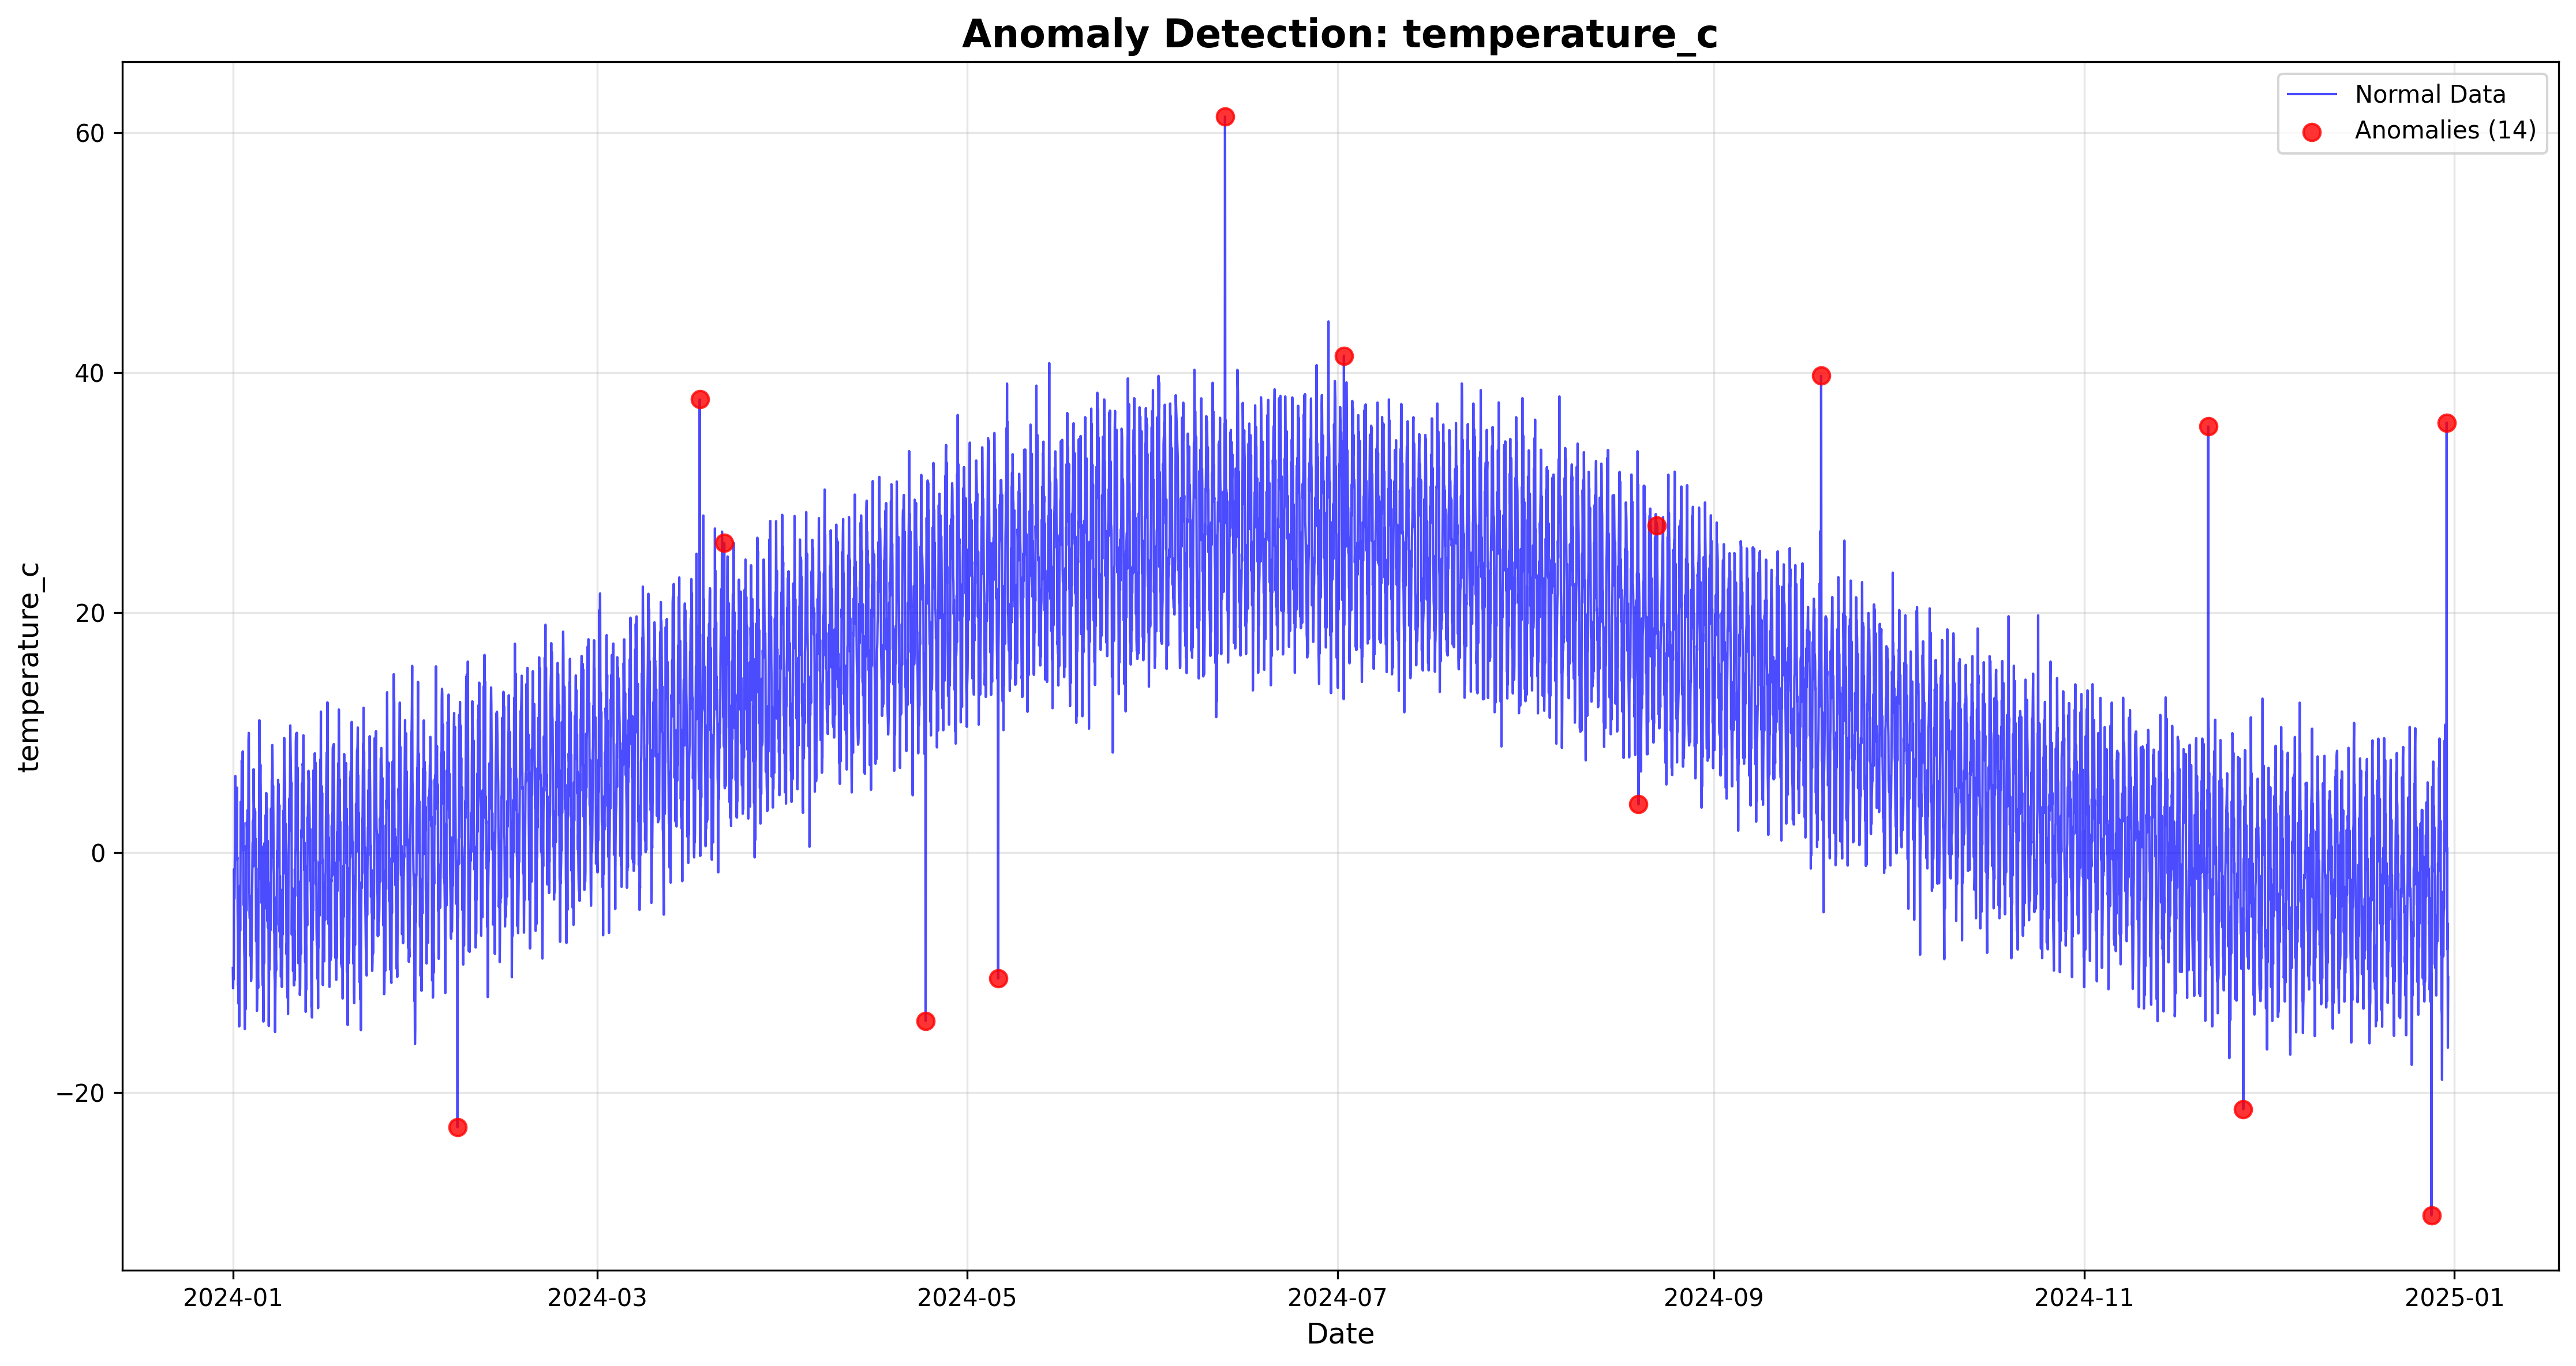

In [7]:
# Plot the anomalies
img_b64 = visualizer.anomalies("temperature_c")
display(HTML(f'<img src="data:image/png;base64,{img_b64}">'))

### Timeseries with trends

In [8]:
# we can get the moving averages with custom windows ...
temp_ma = analyzer.calculate_moving_averages("temperature_c_filled", windows=[7*24, 30*24])
temp_ma

{'7day': {'temperature_c_filled': timestamp
  2024-01-01 00:00:00   -2.541969
  2024-01-01 01:00:00   -2.477122
  2024-01-01 02:00:00   -2.407039
  2024-01-01 03:00:00   -2.337878
  2024-01-01 04:00:00   -2.299379
                           ...   
  2024-12-30 19:00:00   -2.440272
  2024-12-30 20:00:00   -2.484707
  2024-12-30 21:00:00   -2.470853
  2024-12-30 22:00:00   -2.547956
  2024-12-30 23:00:00   -2.598873
  Name: temperature_c_filled, Length: 8760, dtype: float64},
 '30day': {'temperature_c_filled': timestamp
  2024-01-01 00:00:00   -2.029437
  2024-01-01 01:00:00   -2.040325
  2024-01-01 02:00:00   -2.059772
  2024-01-01 03:00:00   -2.068368
  2024-01-01 04:00:00   -2.069636
                           ...   
  2024-12-30 19:00:00   -3.296471
  2024-12-30 20:00:00   -3.285032
  2024-12-30 21:00:00   -3.269619
  2024-12-30 22:00:00   -3.263347
  2024-12-30 23:00:00   -3.259589
  Name: temperature_c_filled, Length: 8760, dtype: float64}}


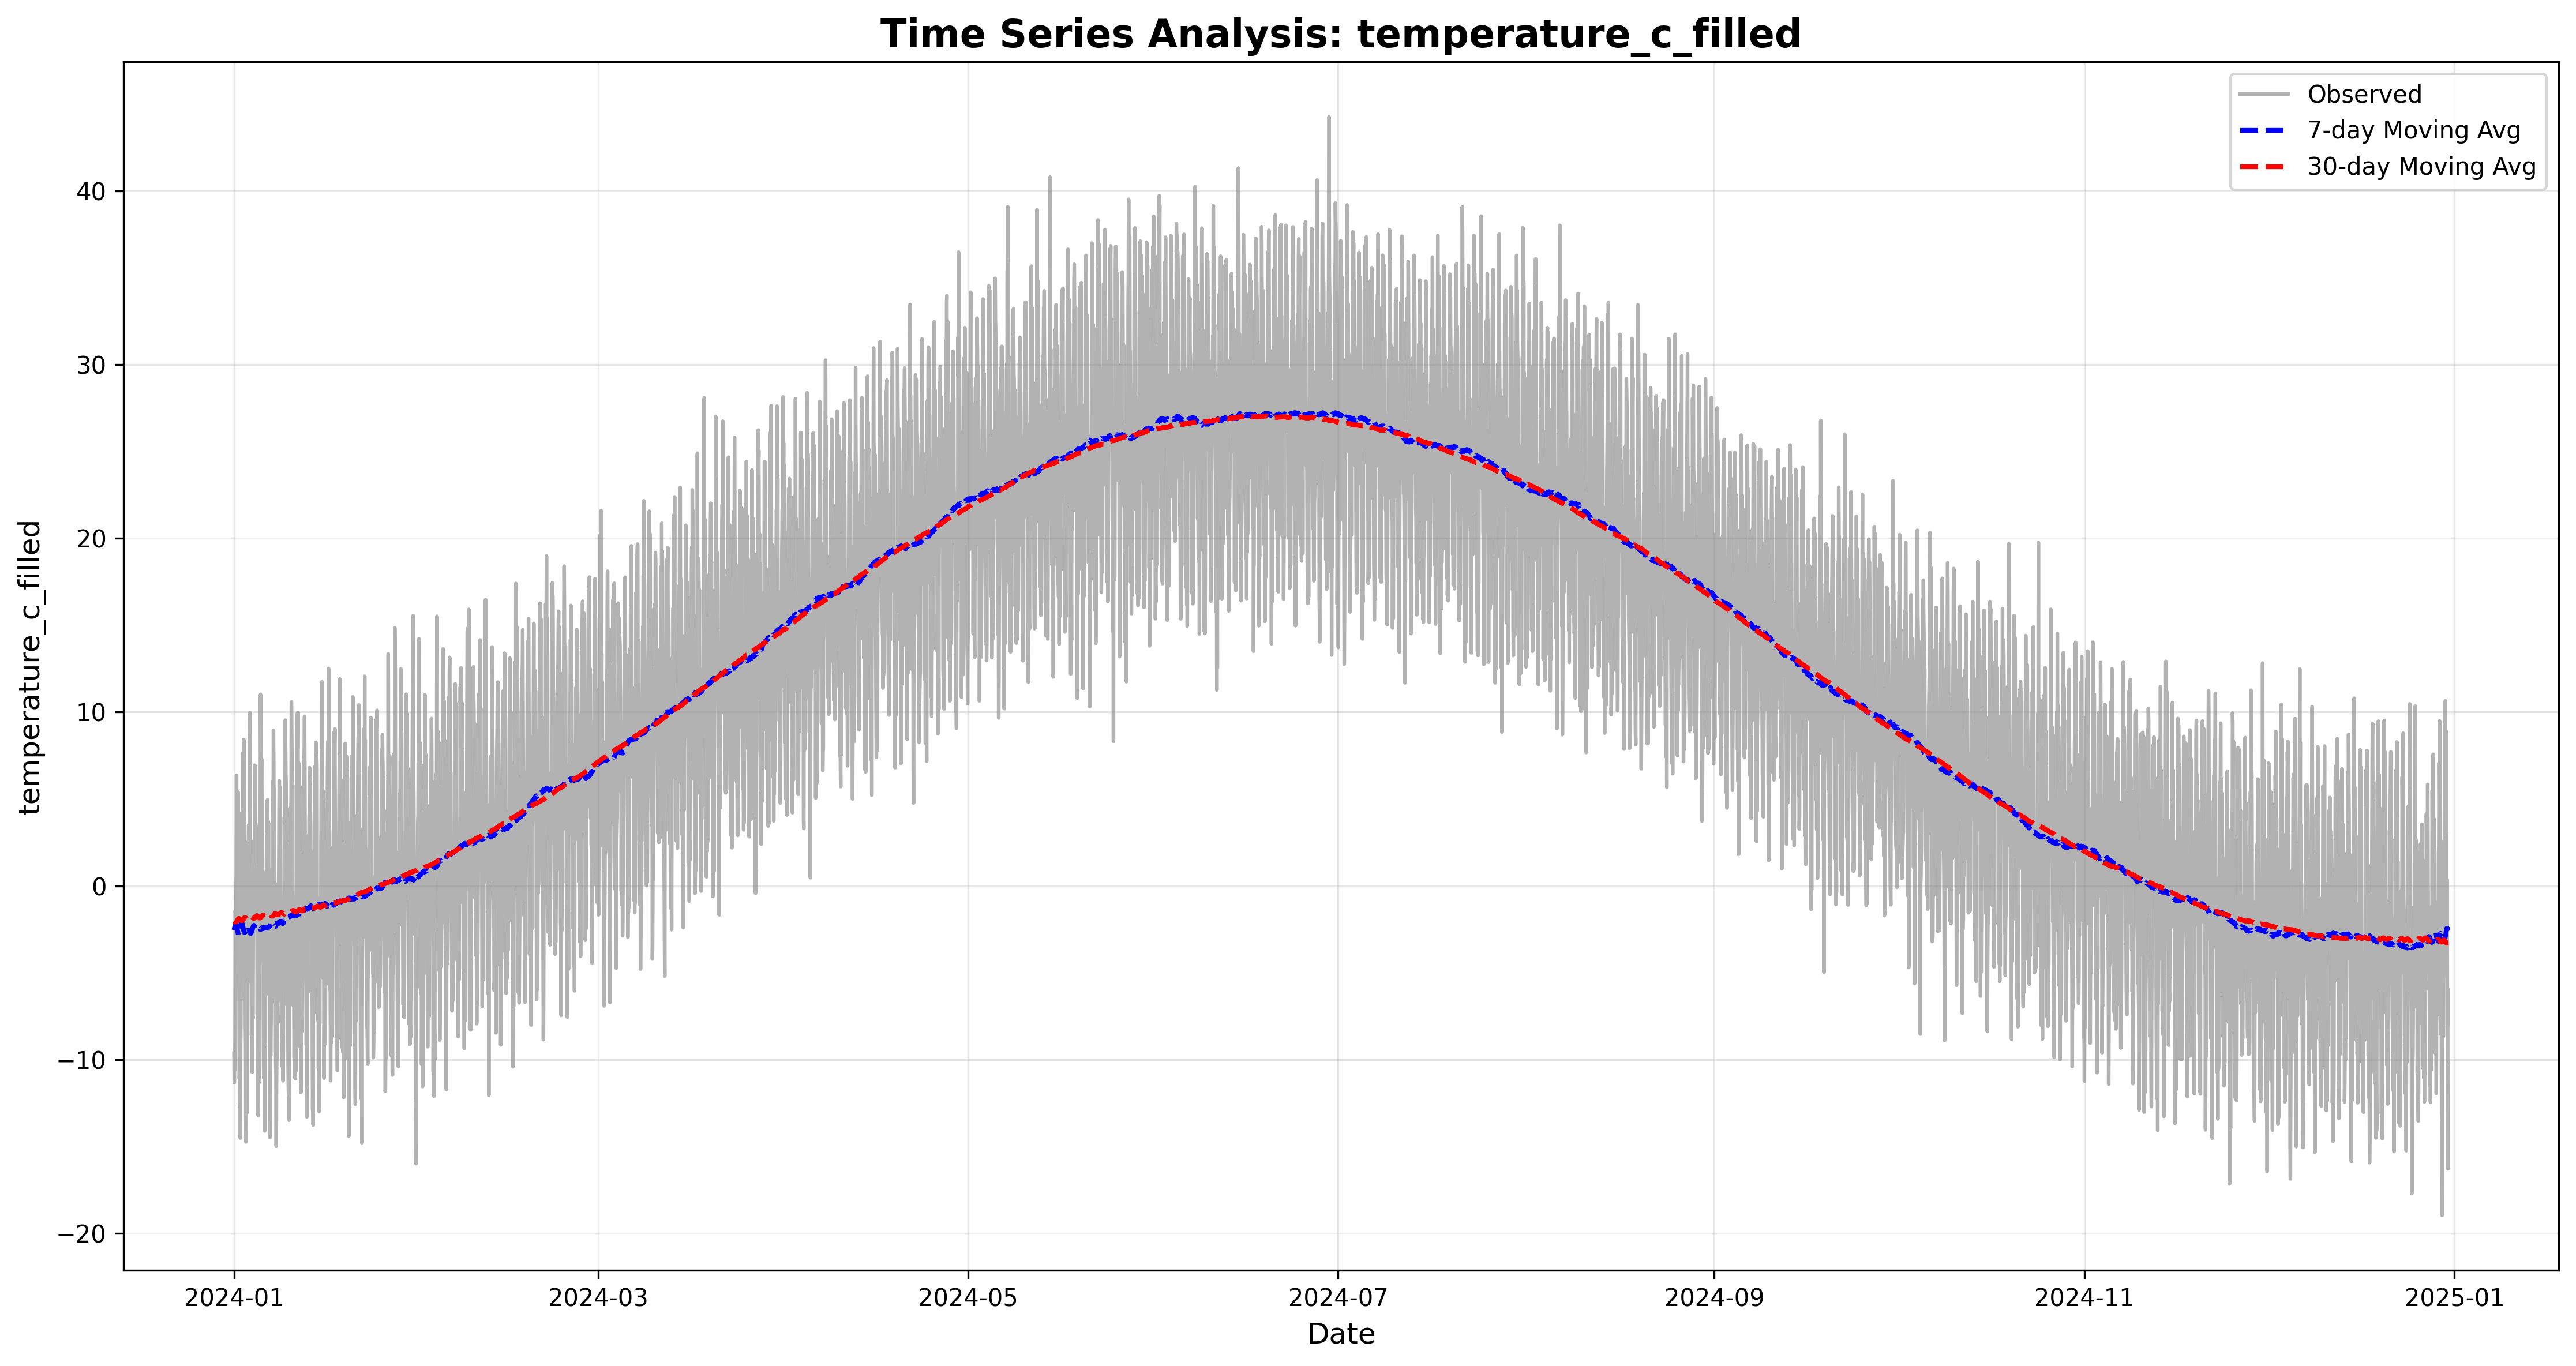

In [9]:
# ... and a plot with moving averages along with observed data
img_b64 = visualizer.timeseries("temperature_c_filled")
display(HTML(f'<img src="data:image/png;base64,{img_b64}">'))

### Trends

In [17]:
# we can get a analysis of the decomposition results and seasonal extremes ...
trends = analyzer.get_trends("air_pressure_hpa")
trends

{'patterns': [{'period': 168,
   'cycles': 52,
   'decomposition': {'mean_peak_time_day': Timedelta('0 days 19:06:15.904888683'),
    'std_peak_time_day': Timedelta('0 days 02:30:55.767371257'),
    'mean_valley_time_day': Timedelta('0 days 09:44:06.519463786'),
    'std_valley_time_day': Timedelta('0 days 03:56:09.953567265'),
    'mean_peak_time_week': Timedelta('1 days 19:03:30.757475949'),
    'std_peak_time_week': Timedelta('0 days 02:27:41.808014742'),
    'mean_valley_time_week': Timedelta('5 days 08:29:05.171338928'),
    'std_valley_time_week': Timedelta('0 days 04:21:11.814217370'),
    'mean_peak_time_year': Timedelta('196 days 17:05:53.816651560'),
    'std_peak_time_year': Timedelta('199 days 16:11:03.264054202'),
    'mean_valley_time_year': Timedelta('177 days 00:25:28.449069349'),
    'std_valley_time_year': Timedelta('198 days 06:30:54.959204312'),
    'mean_amplitude': np.float64(27.093216136442273),
    'std_amplitude': np.float64(1.1515910096662296)},
   'raw_data':

In [11]:
# ... which shows many things, but ...
daily_cycle = trends["patterns"][0]
print("Based on decomposed trends: ")
print(f"Daily temperature high is at {daily_cycle["decomposition"]["mean_peak_time_day"]} with a standard deviation of {daily_cycle['decomposition']['std_peak_time_day']}")
print(f"Daily temperature low is at {daily_cycle["decomposition"]["mean_valley_time_day"]} with a standard deviation of {daily_cycle['decomposition']['std_valley_time_day']}")
print("")
print("Based on raw observed data: ")
print(f"Daily temperature high is at {daily_cycle["raw_data"]["mean_peak_time_day"]} with a standard deviation of {daily_cycle['raw_data']['std_peak_time_day']}")
print(f"Daily temperature low is at {daily_cycle["raw_data"]["mean_valley_time_day"]} with a standard deviation of {daily_cycle['raw_data']['std_valley_time_day']}")
print("")
fall = trends["extremes"]["fall"]
print(f"Lowest temperature during fall was {fall["min"]} at {fall['min_time']}")
print(f"Highest temperature during fall was {fall["max"]} at {fall['max_time']}")
print("and much more...")

Based on decomposed trends: 
Daily temperature high is at 0 days 11:51:29.621069126 with a standard deviation of 0 days 01:23:46.925189463
Daily temperature low is at 0 days 23:59:18.720027986 with a standard deviation of 0 days 01:27:40.748152611

Based on raw observed data: 
Daily temperature high is at 0 days 11:49:14.003376727 with a standard deviation of 0 days 01:48:17.626190702
Daily temperature low is at 0 days 00:02:45.191140755 with a standard deviation of 0 days 01:48:35.129358897

Lowest temperature during fall was -17.15 at 2024-11-24 22:00:00
Highest temperature during fall was 27.5 at 2024-09-01 11:00:00
and much more...


### Distribution

In [12]:
# get a fit of standard distributions
fits = analyzer.fit_distributions("temperature_c_filled")
fits

[('beta',
  np.float64(0.017653184597629323),
  np.float64(0.008406868960299376),
  (np.float64(2.7831699219308623),
   np.float64(2.898277706340492),
   np.float64(-19.161805927325368),
   np.float64(63.57371783332378))),
 ('gamma',
  np.float64(0.03371455733393697),
  np.float64(4.370679131691435e-09),
  (np.float64(174336.55977702342),
   np.float64(-5184.183159093905),
   np.float64(0.029805501505685974))),
 ('norm',
  np.float64(0.03387488646595588),
  np.float64(3.6141738303583545e-09),
  (np.float64(12.005523853688985), np.float64(12.444752011013152))),
 ('weibull_min',
  np.float64(0.034221421019236975),
  np.float64(2.3892922207753405e-09),
  (np.float64(2.9792790877574267),
   np.float64(-21.372815001356194),
   np.float64(37.45746392072256))),
 ('lognorm',
  np.float64(0.03538624307929694),
  np.float64(5.763495182968992e-10),
  (np.float64(0.02553695247475571),
   np.float64(-476.6611227262563),
   np.float64(488.52277213947104))),
 ('expon',
  np.float64(0.2719518838434252

In [13]:
# get best fit based on a Kolmogorov-Smirnov test
best_fit = analyzer.get_best_fit(fits)

Best fit:  beta



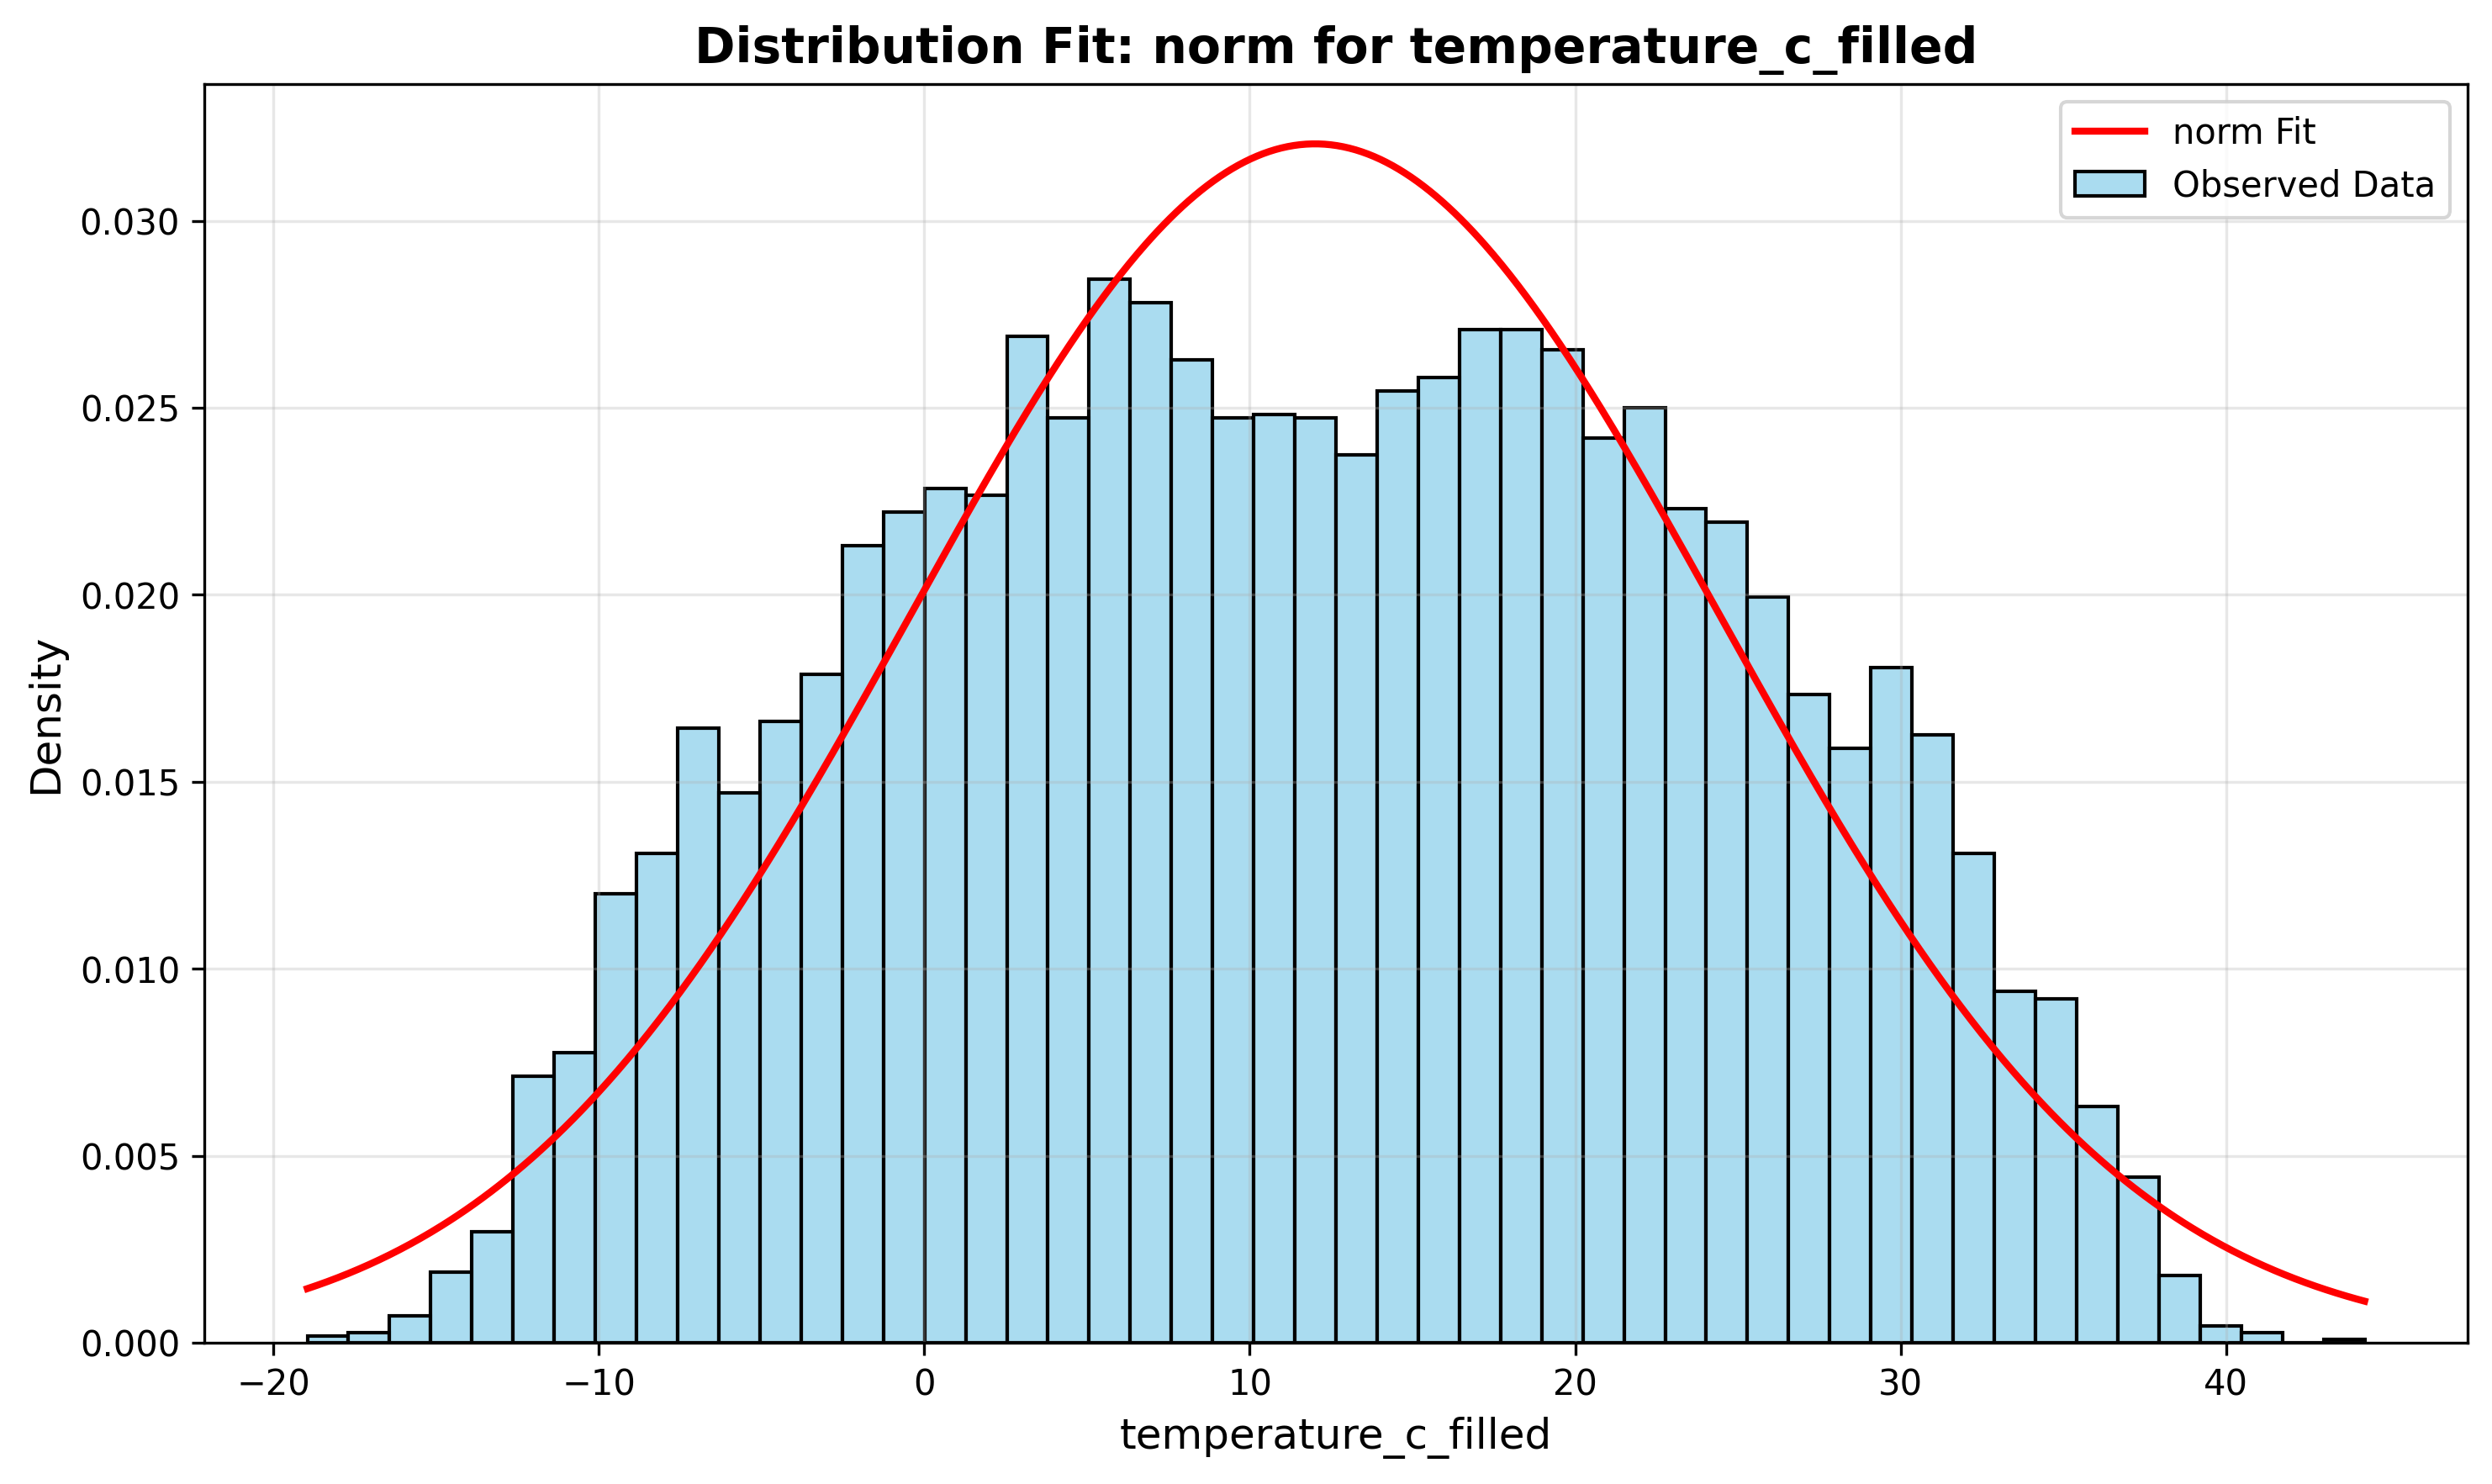


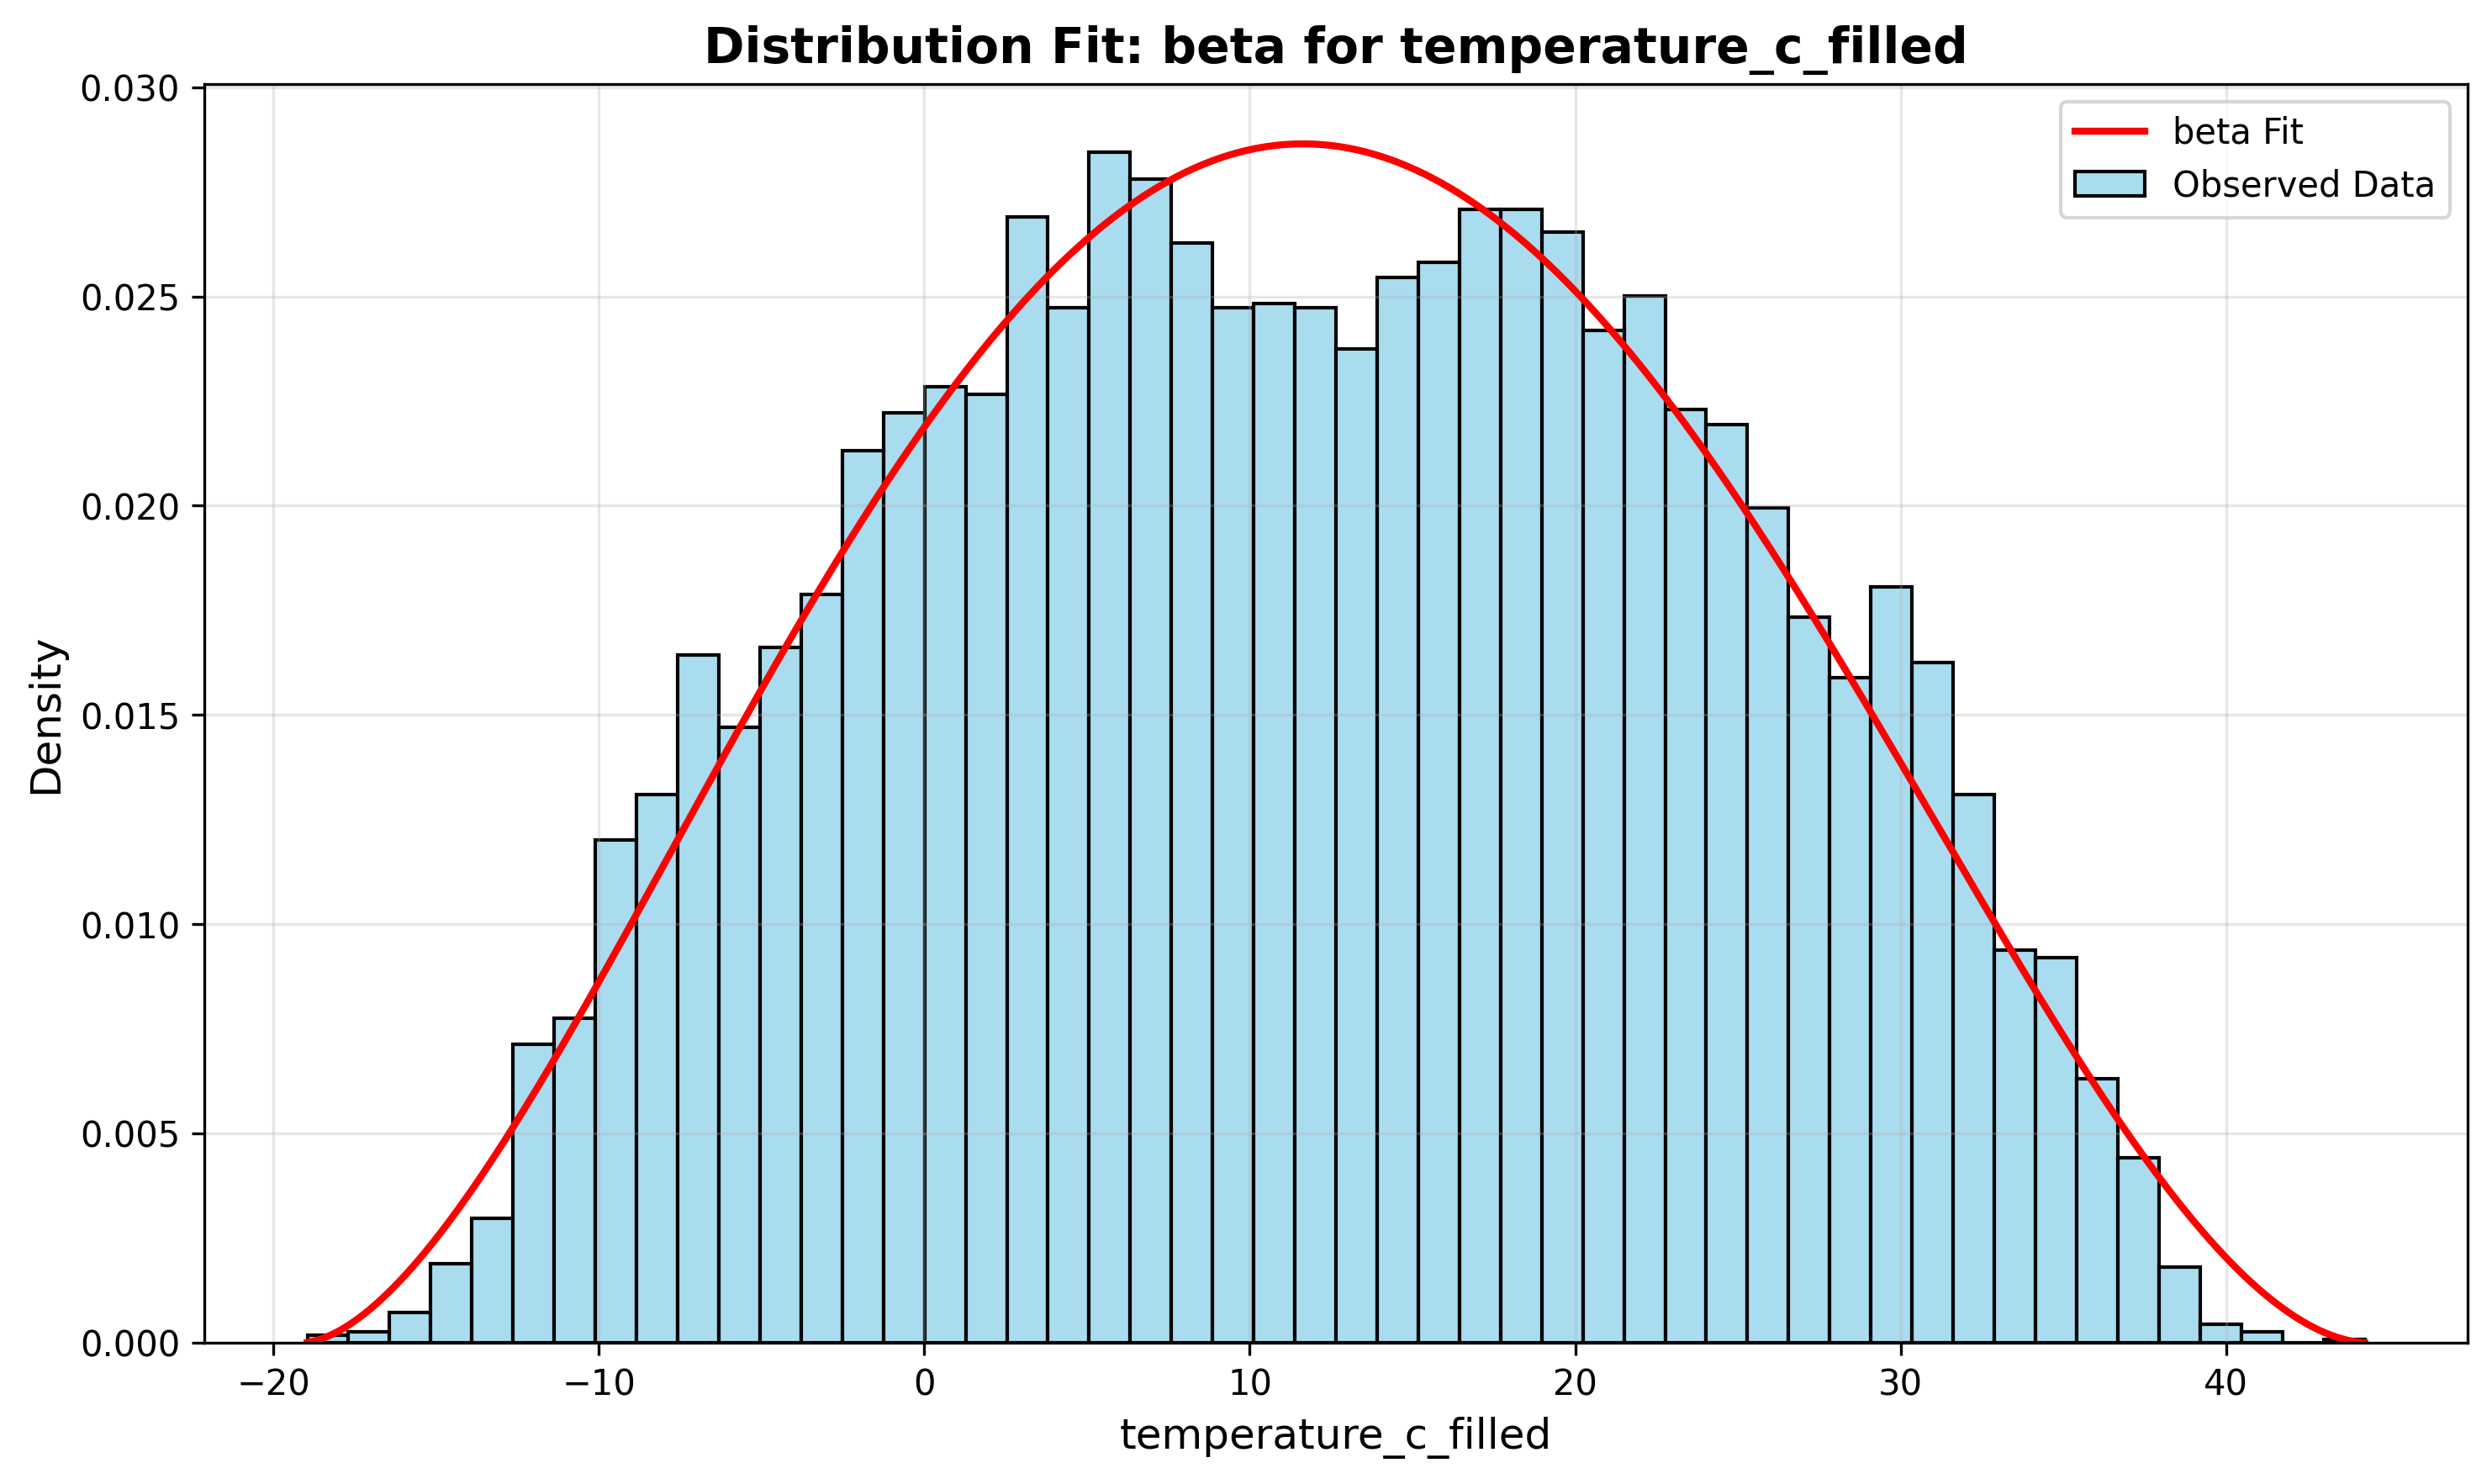

In [14]:
# we can get plots of all the distributions
dists = visualizer.distributions("temperature_c_filled")
# along with information on which is best
print("Best fit: ", dists["best_fit"])
img_b64 = dists["distributions"]["norm"]
display(HTML(f'<img src="data:image/png;base64,{img_b64}">'))
img_b64 = dists["distributions"]["beta"]
display(HTML(f'<img src="data:image/png;base64,{img_b64}">'))

### Correlation

In [15]:
# We can get no-lag correlation matrix with pearson, spearman or kendall
print("No lag")
display(analyzer.get_correlation_matrix(method="spearman"))

# We can get x hours lagged correlation with temperature fixed
print("6 hours lag")
display(analyzer.get_correlation_matrix(method="spearman", lag=6, lag_column="temperature_c_filled"))
print("10 hours lag")
display(analyzer.get_correlation_matrix(method="spearman", lag=10, lag_column="temperature_c_filled"))
print("12 hours lag")
display(analyzer.get_correlation_matrix(method="spearman", lag=12, lag_column="temperature_c_filled"))
print("14 hours lag")
display(analyzer.get_correlation_matrix(method="spearman", lag=14, lag_column="temperature_c_filled"))
print("18 hours lag")
display(analyzer.get_correlation_matrix(method="spearman", lag=18, lag_column="temperature_c_filled"))

# Revealing that Humidity is negatively correlated to temperature with a 12 hours lag

No lag


,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.609030,-0.424745
humidity_percent_filled,-0.609030,1.000000,0.429575
air_pressure_hpa_filled,-0.424745,0.429575,1.000000


6 hours lag


,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.763260,-0.423194
humidity_percent_filled,-0.763260,1.000000,0.429031
air_pressure_hpa_filled,-0.423194,0.429031,1.000000


10 hours lag


,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.912114,-0.422482
humidity_percent_filled,-0.912114,1.000000,0.428393
air_pressure_hpa_filled,-0.422482,0.428393,1.000000


12 hours lag


,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.935841,-0.423124
humidity_percent_filled,-0.935841,1.000000,0.428061
air_pressure_hpa_filled,-0.423124,0.428061,1.000000


14 hours lag


,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.911798,-0.422248
humidity_percent_filled,-0.911798,1.000000,0.427767
air_pressure_hpa_filled,-0.422248,0.427767,1.000000


18 hours lag


,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.762144,-0.421403
humidity_percent_filled,-0.762144,1.000000,0.427302
air_pressure_hpa_filled,-0.421403,0.427302,1.000000



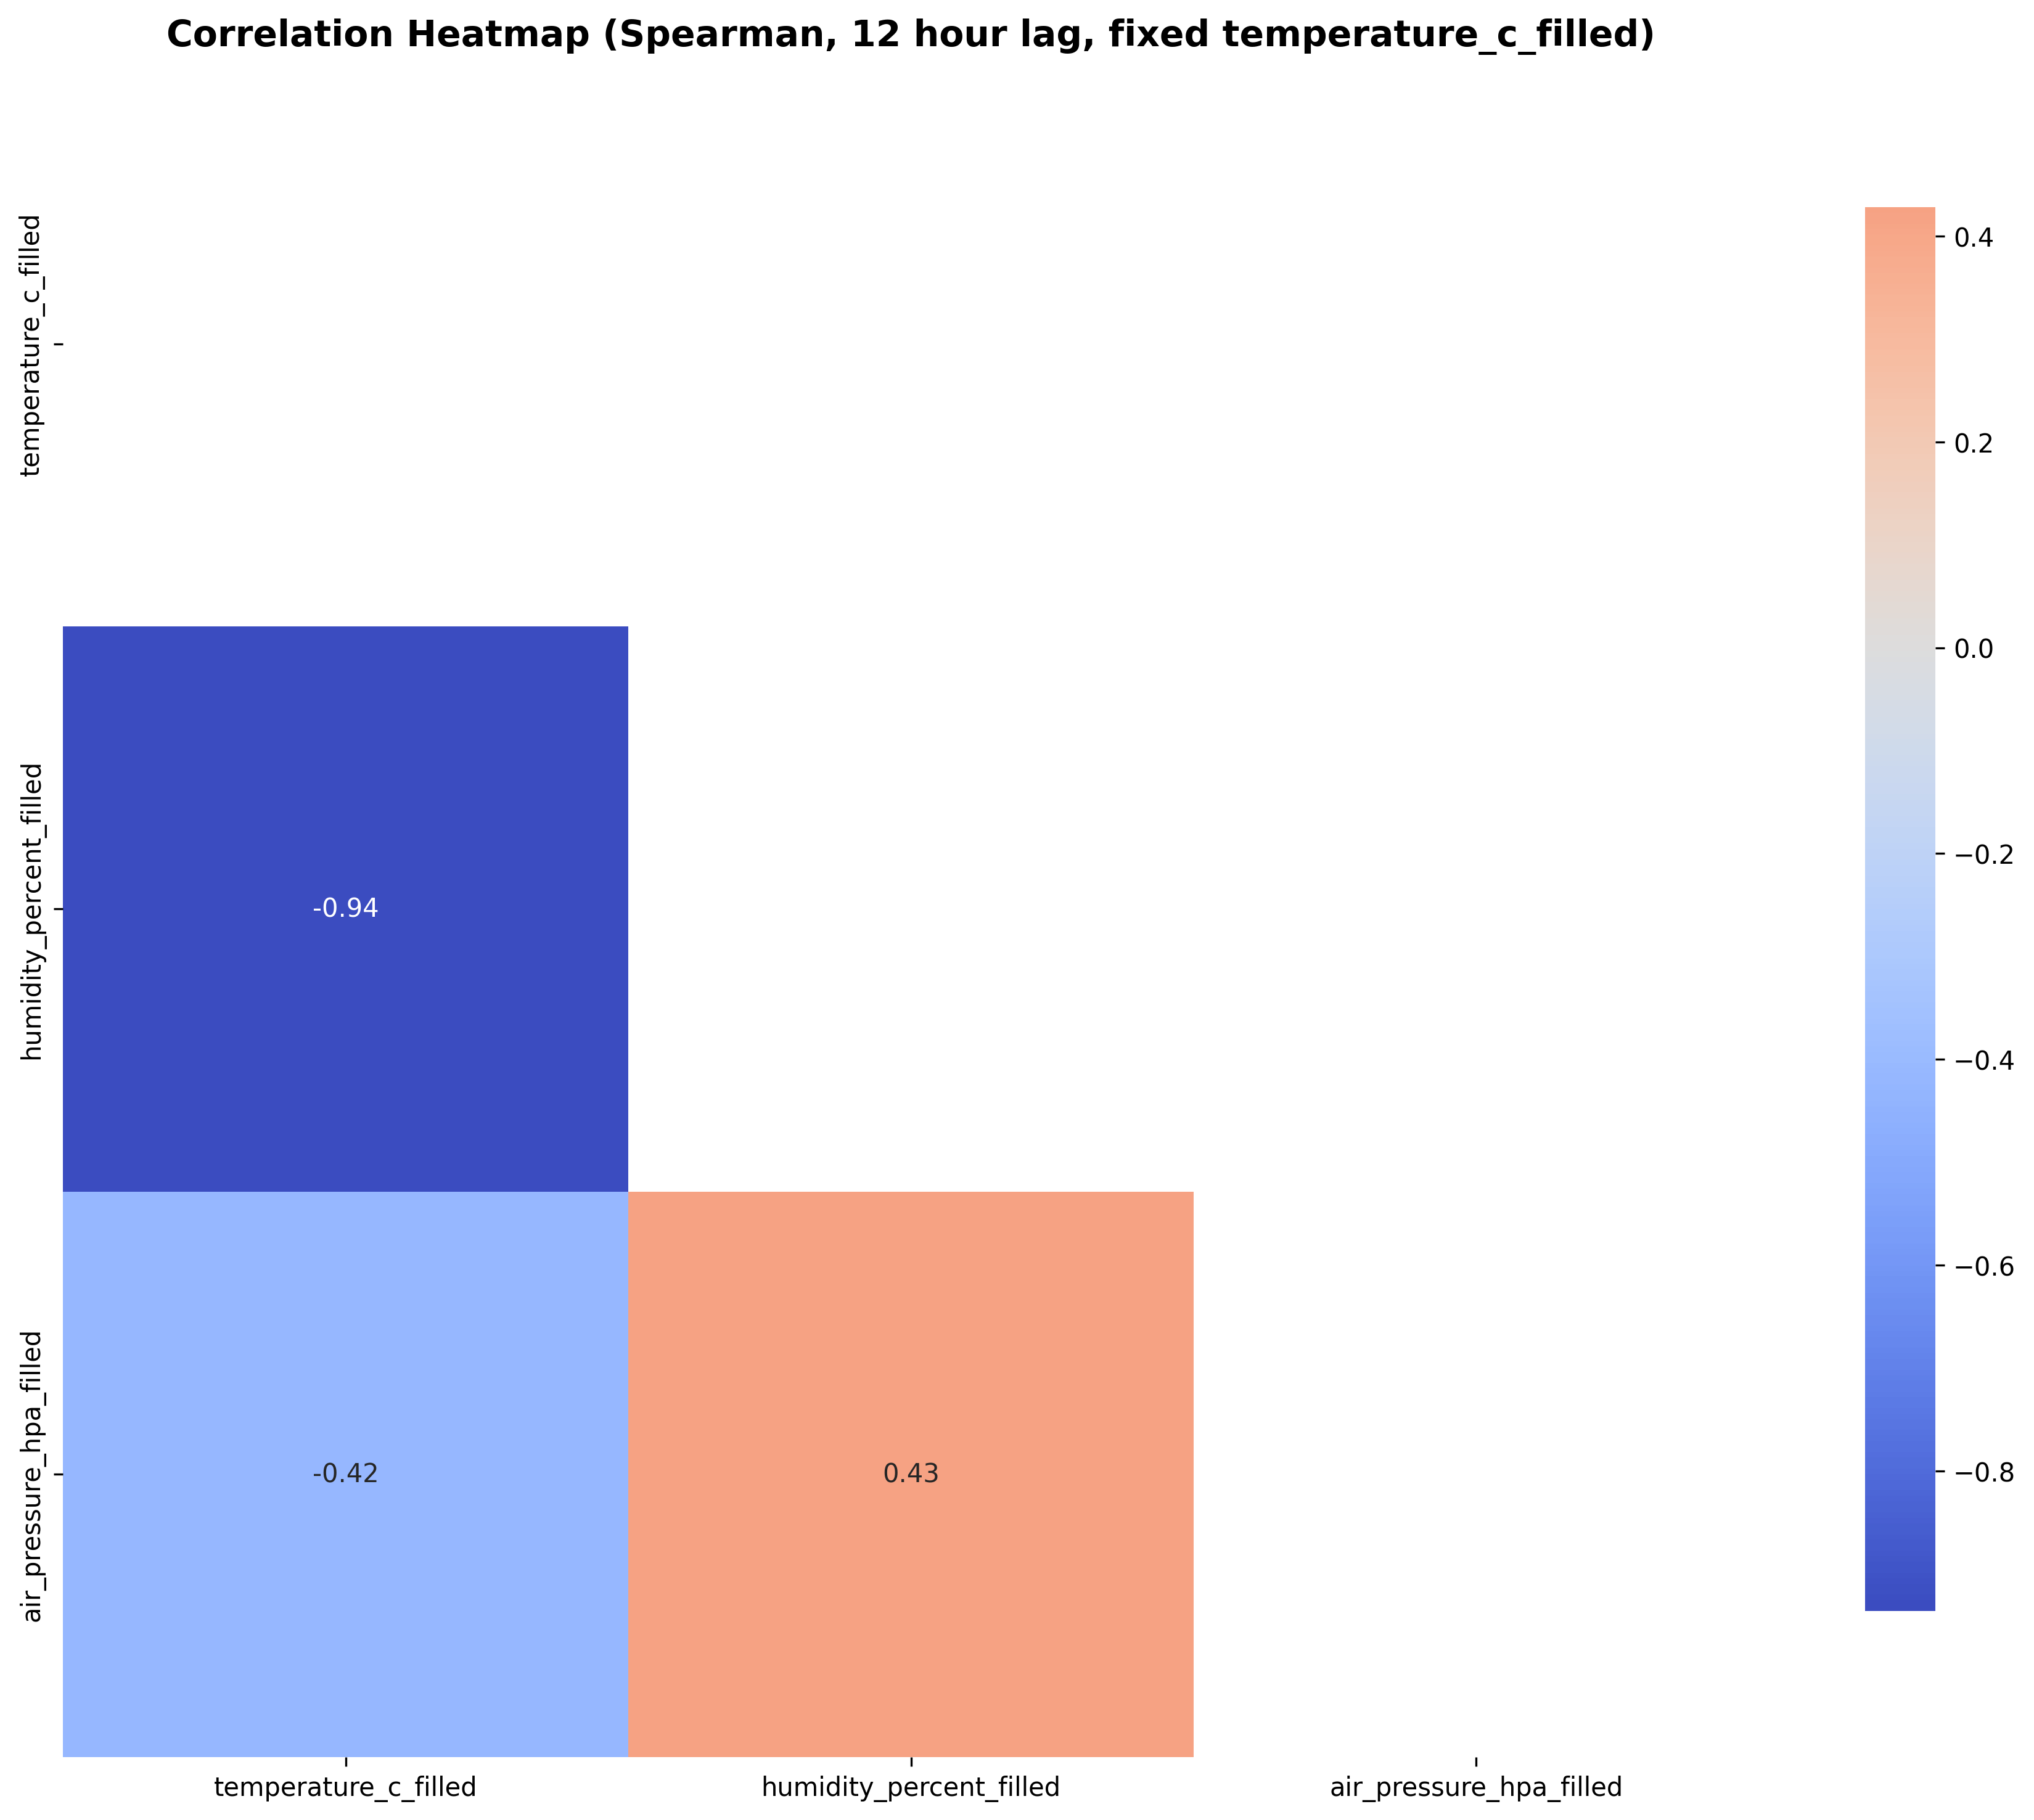

In [16]:
# we can also plot the correlation matrix
img_b64 = visualizer.correlation(method="spearman", lag=12, lag_column="temperature_c_filled")
display(HTML(f'<img src="data:image/png;base64,{img_b64}">'))